# gridfinder
Run through the full gridfinder model from data input to final guess for Burundi.
Note that the 'truth' data used for the grid here is very bad, so the accuracy results don't mean much.

## Before running the notebook

Install the library and its dependencies with, if you haven't done so already
```
pip install -e .
```
from the root directory. You can also execute this command directly in the notebook but will need to reload the
kernel afterwards

In [1]:
# Note - this cell should be executed only once per session
%load_ext autoreload
%autoreload 2

import sys, os

# in order to get the config, it is not part of the library
os.chdir("..")
sys.path.append(os.path.abspath("."))

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import cm
import seaborn as sns
import datetime 

import numpy as np

import folium

from gridfinder.gridfinder import optimise, estimate_mem_use, get_targets_costs
from gridfinder.post import raster_to_lines, thin, threshold_distances
from gridfinder.util.raster import save_2d_array_as_raster, get_clipped_data
from gridfinder.util.loading import open_raster_in_tar
from gridfinder.prepare import merge_rasters, drop_zero_pop, prepare_ntl, prepare_roads
from gridfinder.electrificationfilter import NightlightFilter
from config import get_config

## Set folders and parameters

In [4]:
c = get_config(reload=True)

folder_ntl_in = c.datafile_path("ntl", stage=c.RAW)
aoi_in = c.datafile_path("small_aoi.geojson", stage=c.GROUND_TRUTH)
roads_in = c.datafile_path("smaller_roads.geojson", stage=c.GROUND_TRUTH)
pop_in = c.datafile_path('pop.tif', stage=c.GROUND_TRUTH)
grid_truth = c.datafile_path('grid.gpkg', stage=c.GROUND_TRUTH)

folder_ntl_out = c.datafile_path('ntl_clipped', stage=c.PROCESSED, check_existence=False)
raster_merged_out = c.datafile_path('ntl_merged.tif', stage=c.PROCESSED, check_existence=False)
targets_out =  c.datafile_path('targets.tif', stage=c.PROCESSED, check_existence=False)
targets_clean_out = c.datafile_path('targets_clean.tif', stage=c.CLEANED, check_existence=False)
roads_out = c.datafile_path('roads.tif', stage=c.PROCESSED, check_existence=False)

dist_out = c.datafile_path('dist.tif', stage=c.PROCESSED, check_existence=False)
guess_out = c.datafile_path('guess.tif', stage=c.PROCESSED, check_existence=False)
guess_skeletonized_out = c.datafile_path('guess_skel.tif', stage=c.PROCESSED, check_existence=False)
guess_nulled = c.datafile_path('guess_nulled.tif', stage=c.PROCESSED, check_existence=False)
guess_vec_out = c.datafile_path('guess.gpkg', stage=c.PROCESSED, check_existence=False)
animate_out = os.path.join(c.visualizations, 'guess.tif')

In [5]:
percentile = 70      # percentile value to use when merging monthly NTL rasters
ntl_threshold = 0.1  # threshold when converting filtered NTL to binary (probably shouldn't change)
upsample_by = 2      # factor by which to upsample before processing roads (both dimensions are scaled by this)
cutoff = 0.0         # cutoff to apply to output dist raster, values below this are considered grid
start_date = datetime.date(2016, 1, 1) # Start date for the NTL data to be used. Only includes month if 1st
end_date = datetime.date(2016, 12, 1) # End date for the NTL data to be used. Includes month given here.

## Clip  and merge monthly rasters

In [6]:
# this is necessary until the rest of the notebook has been refactored to use the new saving method
DEFAULT_CRS = "EPSG:4326"


In [14]:
# select the monthly nightlight files that are within the specified date range
ntl_files_basedir = c.datafile_path("ntl")

all_ntl_files = [
        ntl_file
        for ntl_file in os.listdir(ntl_files_basedir)
        if start_date <= datetime.datetime.strptime(ntl_file[:-4], "%Y%m").date() <= end_date
    ]
print(all_ntl_files) # the NTL files that will be merged next.

['201601.tgz', '201602.tgz', '201603.tgz', '201604.tgz', '201605.tgz', '201606.tgz', '201607.tgz', '201608.tgz', '201609.tgz', '201610.tgz', '201611.tgz', '201612.tgz']


In [8]:
aoi_boundary_geodf = gpd.read_file(aoi_in)

ntl_processed_paths = []
for ntl_file in all_ntl_files:
    full_path = os.path.join(ntl_files_basedir, ntl_file)
    ntl_processed_paths.append(os.path.join(folder_ntl_out, f"{ntl_file[:-4]}.tif"))  # stripping off the .tgz
    with open_raster_in_tar(full_path, file_index=1) as raster:
        clipped_data, transform = get_clipped_data(raster, aoi_boundary_geodf)
        save_2d_array_as_raster(ntl_processed_paths[-1], clipped_data, transform, crs=raster.crs.to_string())

Merged


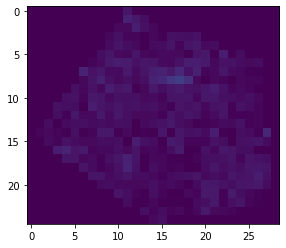

In [9]:
raster_merged, affine, _ = merge_rasters(ntl_processed_paths, percentile=percentile)
save_2d_array_as_raster(raster_merged_out, raster_merged, affine, DEFAULT_CRS)
print('Merged')
plt.imshow(raster_merged, vmin=0, vmax=1)

## Create filter

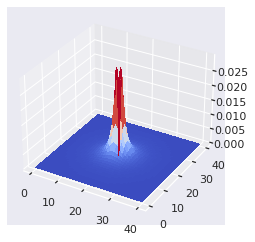

In [10]:
ntl_filter = NightlightFilter()

X = np.fromfunction(lambda i, j: i, ntl_filter.predictor.shape)
Y = np.fromfunction(lambda i, j: j, ntl_filter.predictor.shape)

fig = plt.figure()
sns.set()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, ntl_filter.predictor, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Clip, filter and resample NTL

Targets prepared


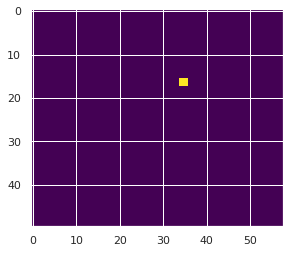

In [11]:
ntl_thresh, affine = prepare_ntl(raster_merged,
                                    affine,
                                    electrification_predictor=ntl_filter,
                                    threshold=ntl_threshold,
                                        upsample_by=upsample_by)
save_2d_array_as_raster(targets_out, ntl_thresh, affine, DEFAULT_CRS)
print('Targets prepared')
plt.imshow(ntl_thresh, cmap='viridis')

## Remove target areas with no underlying population

Removed zero pop


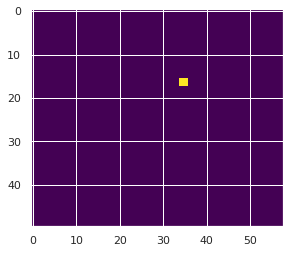

In [12]:
aoi = gpd.read_file(aoi_in)
targets_clean = drop_zero_pop(targets_out, pop_in, aoi)
save_2d_array_as_raster(targets_clean_out, targets_clean, affine, DEFAULT_CRS)
print('Removed zero pop')
plt.imshow(ntl_thresh, cmap='viridis')

## Roads: assign values, clip and rasterize

Costs prepared


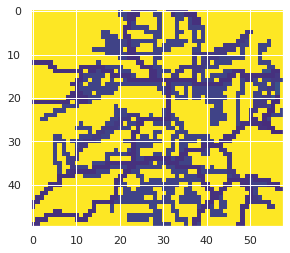

In [13]:
roads_raster, affine = prepare_roads(roads_in,
                                        aoi,
                                        targets_out)
save_2d_array_as_raster(roads_out, roads_raster, affine, DEFAULT_CRS, nodata=-1)
print('Costs prepared')
plt.imshow(roads_raster, cmap='viridis', vmin=0, vmax=1)

## Get targets and costs and run algorithm

In [14]:
targets, costs, start, affine = get_targets_costs(targets_clean_out, roads_out)
est_mem = estimate_mem_use(targets, costs)
print(f'Estimated memory usage: {est_mem:.2f} GB')

Estimated memory usage: 0.00 GB


In [15]:
dist = optimise(targets, costs, start,
                   jupyter=True,
                   animate=True,
                   affine=affine,
                   animate_path=animate_out)
save_2d_array_as_raster(dist_out, dist, affine, DEFAULT_CRS)
plt.imshow(dist)

'99.00 %'

## Filter dist results to grid guess

Got guess


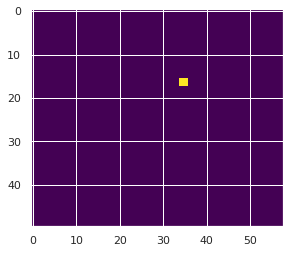

In [16]:
guess = threshold_distances(dist, threshold=cutoff)
save_2d_array_as_raster(guess_out, guess, affine, DEFAULT_CRS)
print('Got guess')
plt.imshow(guess, cmap='viridis')

## Check results

In [79]:
# TODO: the ground truth is not adjusted to the smaller aoi, execution of this cell leads to a shape mismatch

# true_pos, false_neg = gf.accuracy(grid_truth, guess_out, aoi_in)
# print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
# print(f'Actual grid that was missed: {100*false_neg:.0f}%')

## Skeletonize

In [ ]:
guess_skel = thin(guess)
save_2d_array_as_raster(guess_skeletonized_out, guess_skel, affine, DEFAULT_CRS)
print('Skeletonized')
plt.imshow(guess_skel)

In [ ]:
## Convert to geometry

## Convert to geometry

In [ ]:
guess_gdf = raster_to_lines(guess_skel, affine, DEFAULT_CRS)
guess_gdf.to_file(guess_vec_out, driver='GPKG')
print('Converted to geom')

In [ ]:
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
m